In [14]:
import cv2
import os
import numpy as np
import time
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from keras.models import load_model

from pathlib import Path
from joblib import load

In [15]:
dataPath = 'Dataset/images'
picture_size = 96
batch_size  = 64
var_seed = 17
no_of_classes = 2
epochs = 75

In [16]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_set = datagen_train.flow_from_directory(#dataPath+"train",
                                            dataPath,
                                            subset="training",
                                            target_size = (picture_size,picture_size),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True, 
                                            seed  = var_seed)

val_set = datagen_train.flow_from_directory(#dataPath+"test",
                                            dataPath,
                                            subset="validation",
                                            target_size = (picture_size,picture_size),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = False, 
                                            seed  = var_seed)

Found 1124 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [14]:
vgg16 = tf.keras.applications.VGG16(input_shape=(picture_size, picture_size, 3), include_top=False, weights='imagenet')
vgg16.trainable = False

vgg16_model = tf.keras.Sequential([
    vgg16,

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
vgg16_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                      

In [15]:
checkpoint = ModelCheckpoint("models/color/vgg16_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

vgg16_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [16]:
%%time
history = vgg16_model.fit(train_set,
                                epochs=epochs,
                                validation_data = val_set,
                                callbacks=callbacks_list
                                )

Epoch 1/75


18/18 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.7802
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to models/color\vgg16_model.h5
18/18 [==============================] - 19s 952ms/step - loss: 0.6181 - accuracy: 0.7802 - val_loss: 0.4830 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/75


e:\Estudios\DMC\Especializacion MLE\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8817
Epoch 2: val_accuracy did not improve from 0.80000
18/18 [==============================] - 15s 866ms/step - loss: 0.2974 - accuracy: 0.8817 - val_loss: 0.7222 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 3/75
18/18 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9146
Epoch 3: val_accuracy did not improve from 0.80000
18/18 [==============================] - 16s 869ms/step - loss: 0.2150 - accuracy: 0.9146 - val_loss: 0.7516 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 4/75
18/18 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.8932
Epoch 4: val_accuracy did not improve from 0.80000
18/18 [==============================] - 16s 901ms/step - loss: 0.2265 - accuracy: 0.8932 - val_loss: 0.7100 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 5/75
18/18 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9279
Epoch 5: val_accuracy did not improve from 0.80

In [17]:
resnet = tf.keras.applications.ResNet50(input_shape=(picture_size, picture_size, 3), include_top=False, weights='imagenet')
resnet.trainable = False

resnet_model = tf.keras.Sequential([
    resnet,

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    

    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
resnet_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4718848   
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [18]:
checkpoint = ModelCheckpoint("models/color/resnet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

resnet_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [19]:
%%time
history = resnet_model.fit(train_set,
                                epochs=epochs,
                                validation_data = val_set,
                                callbacks=callbacks_list
                                )

Epoch 1/75
18/18 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7660
Epoch 1: val_accuracy improved from -inf to 0.78214, saving model to models/color\resnet_model.h5
18/18 [==============================] - 14s 624ms/step - loss: 0.5800 - accuracy: 0.7660 - val_loss: 0.6385 - val_accuracy: 0.7821 - lr: 0.0010
Epoch 2/75
18/18 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8746
Epoch 2: val_accuracy did not improve from 0.78214
18/18 [==============================] - 10s 533ms/step - loss: 0.3407 - accuracy: 0.8746 - val_loss: 0.6831 - val_accuracy: 0.5857 - lr: 0.0010
Epoch 3/75
18/18 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8630
Epoch 3: val_accuracy improved from 0.78214 to 0.79643, saving model to models/color\resnet_model.h5
18/18 [==============================] - 10s 556ms/step - loss: 0.3197 - accuracy: 0.8630 - val_loss: 0.5158 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 4/75
18/18 [===============

In [20]:
own_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),padding = 'same',input_shape = (96,96,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.25),   
    
    
    tf.keras.layers.Conv2D(128,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.25),    

    tf.keras.layers.Conv2D(128,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.25),       

    tf.keras.layers.Conv2D(256,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30),  
    
    tf.keras.layers.Conv2D(256,(5,5),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30),     
    
    tf.keras.layers.Conv2D(512,(5,5),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30), 
       
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
own_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
own_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 batch_normalization_2 (Bat  (None, 96, 96, 64)        256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 96, 96, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)      

In [21]:
checkpoint = ModelCheckpoint("models/color/own_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


own_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [23]:
%%time
history = own_model.fit(train_set,
                                epochs=epochs,
                                validation_data = val_set,
                                callbacks=callbacks_list
                                )

Epoch 1/75
18/18 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.6699
Epoch 1: val_accuracy improved from -inf to 0.79643, saving model to models/color\own_model.h5
18/18 [==============================] - 18s 868ms/step - loss: 0.7698 - accuracy: 0.6699 - val_loss: 0.5307 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 2/75
18/18 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.7687
Epoch 2: val_accuracy did not improve from 0.79643
18/18 [==============================] - 15s 809ms/step - loss: 0.6238 - accuracy: 0.7687 - val_loss: 0.5262 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 3/75
18/18 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7794
Epoch 3: val_accuracy did not improve from 0.79643
18/18 [==============================] - 15s 826ms/step - loss: 0.4903 - accuracy: 0.7794 - val_loss: 0.5205 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 4/75
18/18 [==============================] - ETA: 0s - loss: 0.4893 - accuracy:

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 193ms/step


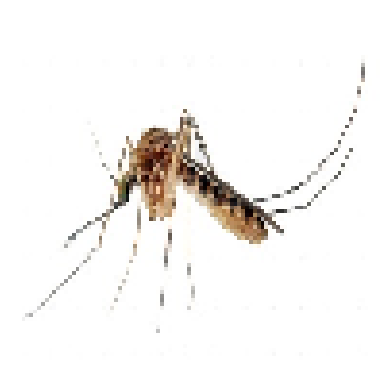

El mosquito es Culex con un 98.04 % de probabilidad


In [94]:
model = tf.keras.models.load_model('E:/Estudios/DMC/Especializacion MLE/models/color/vgg16_model.h5')
image_path = 'E:/Estudios/DMC/Especializacion MLE/Dataset/images/val'
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
picture_size = 96
no_of_classes = 1

image_val = datagen.flow_from_directory(    image_path, 
                                            target_size = (picture_size,picture_size),
                                            class_mode = 'categorical',
                                            batch_size = 1,
                                            shuffle = False)

for x_batch, y_batch in image_val:
    processed_image = x_batch
    break

predictions = model.predict(image_val)

# Mostrar la imagen procesada
plt.imshow(processed_image[0])  # processed_image es un tensor, tomamos el primer elemento
plt.axis('off')  # Desactiva los ejes
plt.show()

first_column = predictions[:, 0]

if predictions[:, 0]>0.5:
    print('El mosquito es Aedes', round(float(first_column[0]*100), 2), '% de probabilidad')
else:
    print('El mosquito es Culex con un', round(float((1-first_column[0])*100), 2), '% de probabilidad')